In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os

from scipy.stats import iqr
from scipy.stats import wilcoxon

from uoineuro.classification_utils import plot_border

%matplotlib inline

In [2]:
results_path = os.path.join(os.environ['HOME'],
                            'fits/uoineuro/classification',
                            'cv_vsmc.h5')

In [3]:
results = h5py.File(results_path, 'r')

In [4]:
c_baseline = results['c_logistic']
c_uoi = results['c_uoi_logistic_bic']
v_baseline = results['v_logistic']
v_uoi = results['v_uoi_logistic_bic']
groups = [c_baseline, c_uoi, v_baseline, v_uoi]
coefs = [group['coefs'][:] for group in groups]
srs = [group['selection_ratios'][:] for group in groups]
scores = [group['scores'][:] for group in groups]

## Metric Summary

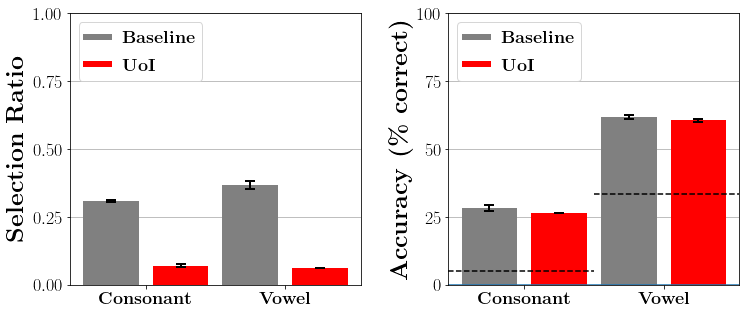

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# selection ratio plot
axes[0].bar(
    x=[0, 1, 2, 3],
    height=[np.median(sr) for sr in srs],
    width=0.8,
    color=['gray', 'red', 'gray', 'red'],
    yerr=[iqr(sr) / 2. for sr in srs],
    error_kw={'capsize': 5, 'elinewidth': 2, 'capthick': 2}
)

# accuracy plot
axes[1].bar(
    x=[0, 1, 2, 3],
    height=[np.median(score) for score in scores],
    width=0.8,
    color=['gray', 'red', 'gray', 'red'],
    yerr=[iqr(score) / 2. for score in scores],
    error_kw={'capsize': 5, 'elinewidth': 2, 'capthick': 2}
)

# chance
axes[1].axhline(y=1./19, xmin=0, xmax=0.5, linestyle='--', color='k')
axes[1].axhline(y=1./3, xmin=0.5, xmax=1, linestyle='--', color='k')

# plot labels
axes[0].set_ylabel(r'\textbf{Selection Ratio}', fontsize=25)
axes[1].set_ylabel(r'\textbf{Accuracy (\% correct)}', fontsize=25)

# cosmetic + legend
for ax in axes:
    # limits
    ax.set_ylim([0, 1.0])
    
    # ticks
    ax.set_xticks([0.5, 2.5])
    ax.set_xticklabels([r'\textbf{Consonant}', r'\textbf{Vowel}'], fontsize=18)
    ax.set_yticks([0, 0.25, 0.50, 0.75, 1.])
    
    # legend labels
    ax.plot([], color='gray', label=r'\textbf{Baseline}')
    ax.plot([], color='r', label=r'\textbf{UoI}')
    lgd = ax.legend(loc=2, prop={'size': 18},
                    handletextpad=0.7,
                    handlelength=1.3)
    for line in lgd.get_lines():
        line.set_linewidth(6.0)

    # gridlines
    ax.grid('on', axis='y')
    ax.set_axisbelow(True)
    
    ax.tick_params(labelsize=18)
    
axes[1].set_yticklabels(['0', '25', '50', '75', '100'])
    
axes[1].axhline()

plt.subplots_adjust(wspace=0.3)

plt.savefig('vsmc_decoding.pdf', bbox_inches='tight')

In [25]:
# statistical tests

print('Selection Ratio, Consonants:', wilcoxon(x=srs[0], y=srs[1]))
print('Selection Ratio, Vowels:', wilcoxon(x=srs[2], y=srs[3]))
print('Accuracy, Consonants:', wilcoxon(x=scores[0], y=scores[1]))
print('Accuracy, Vowels:', wilcoxon(x=scores[2], y=scores[3]))

Selection Ratio, Consonants: WilcoxonResult(statistic=0.0, pvalue=0.043114446783075355)
Selection Ratio, Vowels: WilcoxonResult(statistic=0.0, pvalue=0.04216819709715596)
Accuracy, Consonants: WilcoxonResult(statistic=1.0, pvalue=0.07961580146011343)
Accuracy, Vowels: WilcoxonResult(statistic=3.0, pvalue=0.4652088184521418)


/home/psachdeva/anaconda3/envs/neuro/lib/python3.7/site-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


## Visualize Electrodes

In [6]:
n_total_electrodes = 256
grid_size = int(np.sqrt(n_total_electrodes))
included_electrode_idx = [
    56, 61, 62, 63, 71, 72, 73, 74, 75, 76,
    77, 78, 79, 87, 88, 89, 90, 91, 92, 93,
    94, 95, 102, 103, 104, 105, 106, 107, 108,
    109, 110, 111, 117, 118, 119, 120, 121, 122,
    124, 125, 126, 133, 134, 135, 136, 137, 138,
    139, 140, 141, 142, 143, 149, 150, 151, 152,
    153, 154, 155, 156, 157, 158, 159, 164, 165,
    166, 167, 168, 169, 170, 171, 172, 173, 174,
    175, 181, 182, 183, 184, 185, 186, 187, 188,
    200, 201, 202
]
electrode_mask = np.zeros(n_total_electrodes, dtype=bool)
electrode_mask[included_electrode_idx] = 1
non_electrode_mask = np.invert(electrode_mask)

In [7]:
non_electrode_mask_array = np.ma.masked_array(
    data=np.zeros(n_total_electrodes),
    mask=electrode_mask).reshape((grid_size, grid_size))

In [8]:
examples = [0, 1, 5]
n_examples = len(examples)
log_grids = [np.zeros(n_total_electrodes) for _ in range(n_examples)]
uoi_grids = [np.zeros(n_total_electrodes) for _ in range(n_examples)]

for idx, example in enumerate(examples):
    log_grids[idx][included_electrode_idx] = np.median(coefs[0], axis=0)[example]
    uoi_grids[idx][included_electrode_idx] = np.median(coefs[1], axis=0)[example]

log_grids_masked = [np.ma.masked_array(
    data=log_grid,
    mask=non_electrode_mask).reshape((grid_size, grid_size))
    for log_grid in log_grids]
uoi_grids_masked = [np.ma.masked_array(
    data=uoi_grid,
    mask=non_electrode_mask).reshape((grid_size, grid_size))
    for uoi_grid in uoi_grids]

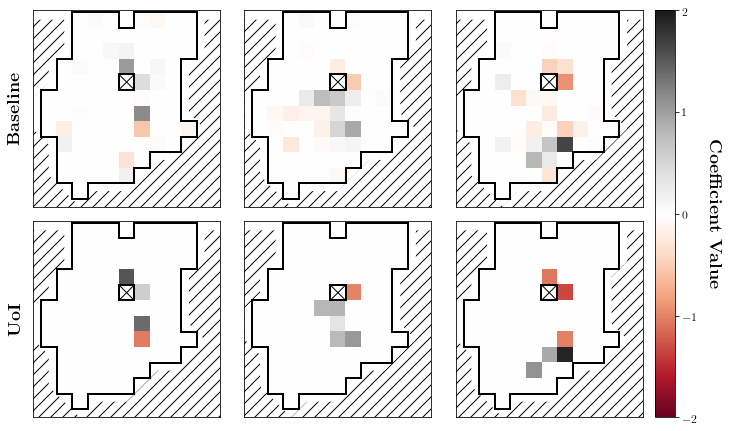

In [89]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6))

    
for example in range(n_examples):
    img = axes[0][example].imshow(
        np.flip(log_grids_masked[example].T, axis=(1)),
        cmap='RdGy',
        vmin=-2,
        vmax=2)
    axes[1][example].imshow(
        np.flip(uoi_grids_masked[example].T, axis=(1)),
        cmap='RdGy',
        vmin=-2,
        vmax=2)
    
for ax in axes.ravel():
    ax.contourf(np.flip(non_electrode_mask_array.T, axis=(1)), 1, hatches=['//'], alpha=0)
    ax.set_xticks([])
    ax.set_yticks([])
    plot_border(x=4, y=15, which='right', ax=ax)
    plot_border(x=4, y=14, which='right', ax=ax)
    plot_border(x=4, y=13, which='right', ax=ax)
    plot_border(x=4, y=13, which='bottom', ax=ax)
    plot_border(x=3, y=12, which='right', ax=ax)
    plot_border(x=3, y=11, which='right', ax=ax)
    plot_border(x=3, y=11, which='bottom', ax=ax)
    plot_border(x=2, y=10, which='right', ax=ax)
    plot_border(x=2, y=10, which='right', ax=ax)
    plot_border(x=2, y=9, which='right', ax=ax)
    plot_border(x=2, y=8, which='right', ax=ax)
    plot_border(x=3, y=7, which='top', ax=ax)
    plot_border(x=3, y=7, which='right', ax=ax)
    plot_border(x=3, y=6, which='right', ax=ax)
    plot_border(x=3, y=5, which='right', ax=ax)
    plot_border(x=4, y=4, which='top', ax=ax)
    plot_border(x=4, y=4, which='right', ax=ax)
    plot_border(x=5, y=4, which='bottom', ax=ax)
    plot_border(x=5, y=4, which='right', ax=ax)
    plot_border(x=6, y=4, which='top', ax=ax)
    plot_border(x=7, y=4, which='top', ax=ax)
    plot_border(x=8, y=4, which='top', ax=ax)
    plot_border(x=9, y=5, which='left', ax=ax)
    plot_border(x=9, y=5, which='top', ax=ax)
    plot_border(x=10, y=6, which='left', ax=ax)
    plot_border(x=10, y=6, which='top', ax=ax)
    plot_border(x=11, y=6, which='top', ax=ax)
    plot_border(x=12, y=7, which='left', ax=ax)
    plot_border(x=12, y=7, which='top', ax=ax)
    plot_border(x=12, y=8, which='right', ax=ax)
    plot_border(x=12, y=8, which='top', ax=ax)
    plot_border(x=12, y=9, which='left', ax=ax)
    plot_border(x=12, y=10, which='left', ax=ax)
    plot_border(x=12, y=11, which='left', ax=ax)
    plot_border(x=12, y=12, which='left', ax=ax)
    plot_border(x=12, y=12, which='top', ax=ax)
    plot_border(x=13, y=13, which='left', ax=ax)
    plot_border(x=13, y=14, which='left', ax=ax)
    plot_border(x=13, y=15, which='left', ax=ax)
    plot_border(x=12, y=15, which='top', ax=ax)
    plot_border(x=11, y=15, which='top', ax=ax)
    plot_border(x=10, y=15, which='top', ax=ax)
    plot_border(x=9, y=15, which='top', ax=ax)
    plot_border(x=8, y=15, which='right', ax=ax)
    plot_border(x=8, y=15, which='bottom', ax=ax)
    plot_border(x=8, y=15, which='left', ax=ax)
    plot_border(x=7, y=15, which='top', ax=ax)
    plot_border(x=6, y=15, which='top', ax=ax)
    plot_border(x=5, y=15, which='top', ax=ax)
    plot_border(x=8, y=11, which='top', ax=ax)
    plot_border(x=8, y=11, which='bottom', ax=ax)
    plot_border(x=8, y=11, which='right', ax=ax)
    plot_border(x=8, y=11, which='left', ax=ax)
    ax.plot(np.linspace(7.5, 8.5, 1000), np.linspace(10.5, 11.5, 1000), color='k', linewidth=1)
    ax.plot(np.linspace(7.5, 8.5, 1000), np.linspace(11.5, 10.5, 1000), color='k', linewidth=1)

    ax.set_xlim([2, 14])
    ax.set_ylim([3, 15.6])

plt.tight_layout()

axes[0, 0].set_ylabel(r'\textbf{Baseline}', fontsize=18, labelpad=10)
axes[1, 0].set_ylabel(r'\textbf{UoI}', fontsize=18, labelpad=10)

cax = fig.add_axes([0.99, 0.033, 0.03, 0.942])
cb = fig.colorbar(img, cax=cax, orientation='vertical')
cb.ax.tick_params(labelsize=12)
cb.set_ticks([-2, -1, 0, 1, 2])
cb.set_label(r'\textbf{Coefficient Value}',
             labelpad=25,
             rotation=270,
             fontsize=18)

plt.savefig('vsmc_electrodes.pdf', bbox_inches='tight')